[First](#First)  
[Second](#Second)  
[Training](#Training)  
[Imbalance](#Imbalance)

# First

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import random
import os

In [ ]:
with open('../Data/preprocessed.pkl.zip', 'rb') as f:
    _ = pickle.load(f)
    col_names = pickle.load(f)
    X = pickle.load(f)
    y = pickle.load(f)
    cat_slice = pickle.load(f)
    skewed_slice = pickle.load(f)
    non_skewed_slice = pickle.load(f)
    '''
    X_train = pickle.load(f)
    X_test = pickle.load(f)
    y_train = pickle.load(f)
    y_test = pickle.load(f)
    '''    

In [ ]:
col_names, X.shape, y.shape, cat_slice, skewed_slice, non_skewed_slice

In [ ]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #X_cat = X[:, cat_slice]
        #X_skewed = X[:, skewed_slice]
        #X_non_skewed = X[:, non_skewed_slice]
        
        #q_transformer = QuantileTransformer()
        #q_transformer.fit(X_skewed)

        X = sparse.hstack([X[:, cat_slice], QuantileTransformer().fit_transform(X[:, skewed_slice]), X[:, non_skewed_slice]], format='csr')
        
        #Making the matrices dense
        #X_non_skewed_dense = X_non_skewed.toarray()

        #Initializing and fitting the scaler
        #scaler = StandardScaler()
        #scaler.fit(X_non_skewed_dense)

        #Applying the scaling t+
        # eo the dense matrices
        #X_non_skewed_dense = scaler.transform(X_non_skewed_dense)

        #Making the matrices sparse again
        #X_non_skewed = sparse.csr_matrix(X_non_skewed_dense)
        
        #X_non_skewed = sparse.csr_matrix(StandardScaler().fit_transform(X[:, non_skewed_slice].toarray())) 
        X = sparse.hstack([X[:, cat_slice], X[:, skewed_slice], sparse.csr_matrix(StandardScaler().fit_transform(X[:, non_skewed_slice].toarray()))], format='csr')
        
        #del X_non_skewed
        
        #X = sparse.hstack([X_cat, X_skewed, X_non_skewed])
        
        return X

In [ ]:
pipeline = Pipeline([('transformation', CustomTransformer()), ('log_regression', LogisticRegression(max_iter=10000))])

In [ ]:
%%time

cv_scores = cross_val_score(pipeline, X, y, scoring='roc_auc')

In [ ]:
path = '../Data/first_log_model.pkl'
if not os.path.exists(path):
    logistic_regressor = LogisticRegression(max_iter=10000)
    logistic_regressor.fit(X_train, y_train)
    with open(path, 'wb') as f:
        pickle.dump(logistic_regressor, f)
else:
    with open(path, 'rb') as f:
        logistic_regressor = pickle.load(f)

In [ ]:
y_pred = logistic_regressor.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()

In [ ]:
y_pred_rand = [random.uniform(0, 1) for x in y_test]
RocCurveDisplay.from_predictions(y_test, y_pred_rand)
plt.show()

In [ ]:
y_pred_prob = logistic_regressor.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_train_train_train_test, y_pred_prob)
plt.show()

In [ ]:
def plot_logistic_feature_importance(coefficients, feature_names, number):
    coef_enum = enumerate(coefficients)
    coef_enum_sorted_top = sorted(coef_enum, key=lambda x: abs(x[1]), reverse=True)[:number]
    
    indices = list(list(zip(*coef_enum_sorted_top))[0])
    names = feature_names[indices]
    top_coef = np.array(list(zip(*coef_enum_sorted_top))[1])
    
    neg_pos = np.where(top_coef < 0)[0]
    pos_pos = np.where(top_coef >= 0)[0]
    neg_coef = top_coef[neg_pos]
    pos_coef = top_coef[pos_pos]
    neg_names = names[neg_pos]
    pos_names = names[pos_pos]
    
    _, ax = plt.subplots()
    
    ax.bar(neg_pos, np.abs(neg_coef), color='r', label='negative')
    ax.bar(pos_pos, np.abs(pos_coef), color='b', label='positive')
    ax.set_xticks(range(0, len(names)))
    ax.set_xticklabels(names, rotation=90)
    ax.set_title('Top Features by Absolute Value of Model Coefficient')
    ax.set_ylabel('Feature Coefficient')
    ax.set_xlabel('Features')
    
    ax.legend()
    plt.show()

In [ ]:
plot_logistic_feature_importance(logistic_regressor.coef_[0], col_names, 20)

In [ ]:
cv_score_list = cross_val_score(logistic_regressor, X_train, y_train, scoring='roc_auc')
print(f'CV scores: {cv_score_list}\nAverage: {cv_score_list.mean()}\nStandard Deviation: {cross_val_score.std()}')

In [ ]:
print(f'CV Scores: {cv_score_list}\nAverage: {cv_score_list.mean()}\nStandard Deviation: {cv_score_list.std()}')

# Second

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import sparse
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
import random
import os

In [2]:
path = '../Data/df_clean_null.pkl'
df = pd.read_pickle(path)

In [3]:
feature_names = ['_RFHLTH', '_HCVU651', '_RFHYPE5', '_RFCHOL', '_ASTHMS1', '_DRDXAR1', '_RACEGR3', '_AGE_G', '_BMI5CAT', '_EDUCAG', '_INCOMG', '_SMOKER3',\
    '_RFDRHV5', '_PACAT1', '_RFSEAT2', '_FLSHOT6', '_PNEUMO2', '_AIDTST3', 'CHCCOPD1', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL', 'DRADVISE']
target_name = ['_MICHD']
weights_name = ['_LLCPWT'] 

In [4]:
df = df[feature_names + target_name + weights_name]
df

,_RFHLTH,_HCVU651,_RFHYPE5,_RFCHOL,_ASTHMS1,_DRDXAR1,_RACEGR3,_AGE_G,_BMI5CAT,_EDUCAG,...,_AIDTST3,CHCCOPD1,ADDEPEV2,CHCKIDNY,DIABETE3,SEX,MARITAL,DRADVISE,_MICHD,_LLCPWT
0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,5.0,4.0,2.0,...,1.0,1.0,1.0,2.0,3.0,2.0,1.0,NaN,2.0,341.384853
1,1.0,2.0,1.0,1.0,3.0,2.0,1.0,4.0,3.0,4.0,...,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,108.060903
2,2.0,9.0,1.0,2.0,3.0,1.0,1.0,6.0,2.0,2.0,...,NaN,2.0,2.0,2.0,3.0,2.0,2.0,NaN,NaN,255.264797
3,2.0,1.0,2.0,2.0,3.0,1.0,1.0,5.0,3.0,2.0,...,9.0,2.0,1.0,2.0,3.0,2.0,1.0,2.0,2.0,341.384853
4,2.0,1.0,1.0,1.0,3.0,1.0,1.0,5.0,2.0,3.0,...,1.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,258.682223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,2.0,9.0,2.0,2.0,3.0,1.0,5.0,6.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,2.0,3.0,1.0,2.0,531.980410
441452,1.0,1.0,1.0,1.0,3.0,2.0,5.0,2.0,3.0,3.0,...,1.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,746.416599
441453,2.0,9.0,2.0,2.0,3.0,2.0,5.0,6.0,4.0,2.0,...,NaN,2.0,2.0,2.0,3.0,2.0,1.0,NaN,2.0,207.663634
441454,1.0,1.0,2.0,1.0,3.0,2.0,5.0,4.0,2.0,3.0,...,2.0,2.0,2.0,2.0,3.0,1.0,5.0,1.0,2.0,515.758894


In [5]:
for column in ['_RFHYPE5', '_RFCHOL', '_RFDRHV5']:
    df[column] = df[column].apply(lambda x: 1.0 if x == 2.0 else 2.0 if x == 1.0 else x)

In [6]:
for column in ['_FLSHOT6', '_PNEUMO2']:
    df[column] = df[column].cat.add_categories([65.0])
    df[column] = df[column].fillna(65.0)

In [7]:
df['DIABETE3'] = df['DIABETE3'].map({1.0:1.0, 2.0:1.0, 3.0:2.0, 4.0:2.0, 7.0:7.0, 9.0:9.0}).astype('category')

In [8]:
df['_MICHD'] = df['_MICHD'].apply(lambda x: 0.0 if x == 2 else x)

In [9]:
def imputer(dataframe, category_value_tofill=None, columns_drop=None, columns_mode=None, columns_median=None):
    '''Imputes missing values to the input dataframe.
    
       Parameters
       ----------
       dataframe: Pandas dataframe
           dataframe with which to impute missing values.
       
       category_value_tofill: int, float, or string
           Value to used to fill missing values in categorical features.
       
       columns_drop: list-like
           List of columns to drop.
       
       columns_mode: list-like
           List of numeric columns to impute with the mode.
           
       columns_median: list-like
           List of numeric columns to impute with the mean.
    '''
    #Fill null values in categorical features with value_null
    if category_value_tofill != None:
        for column in dataframe.select_dtypes(include='category').columns:
            if any(dataframe[column].isnull()):
                dataframe[column] = dataframe[column].cat.add_categories([category_value_tofill])
                dataframe[column] = dataframe[column].fillna(value=category_value_tofill)
            
    #Droping columns, imputing with mode, and imputing with median.
    if columns_drop != None:
        dataframe = dataframe.drop(columns=columns_drop)
    if columns_mode != None:
        dataframe = dataframe.fillna(dataframe[columns_mode].mode().iloc[0, :])
    if columns_median != None:
        dataframe = dataframe.fillna(dataframe[columns_median].median())
    
    return dataframe

In [10]:
df = imputer(df, 999.0)

In [11]:
trans_list = ['Good_Health', 'Health_Insurance', 'Hypertension', 'High_Cholesterol', 'Asthma_Status', 'Arthritis', 'Race', 'Age_Cat', 'BMI_Cat', 'Education_Level', 'Income_Level', \
    'Smoker_Status', 'Heavy_Drinker', 'Physical_Activity', 'Seatbelt', 'Flu_Shot', 'Pneumonia_Vaccine', 'HIV', 'Bronchitis', 'Depression', 'Kidney_Disease', 'Diabetes', 'SEX', \
        'Marital Status', 'Sodium', 'Heart_Disease', 'Sample_Weights']

In [12]:
trans_dict = dict(zip(feature_names + target_name + weights_name, trans_list))
trans_dict

{'_RFHLTH': 'Good_Health',
 '_HCVU651': 'Health_Insurance',
 '_RFHYPE5': 'Hypertension',
 '_RFCHOL': 'High_Cholesterol',
 '_ASTHMS1': 'Asthma_Status',
 '_DRDXAR1': 'Arthritis',
 '_RACEGR3': 'Race',
 '_AGE_G': 'Age_Cat',
 '_BMI5CAT': 'BMI_Cat',
 '_EDUCAG': 'Education_Level',
 '_INCOMG': 'Income_Level',
 '_SMOKER3': 'Smoker_Status',
 '_RFDRHV5': 'Heavy_Drinker',
 '_PACAT1': 'Physical_Activity',
 '_RFSEAT2': 'Seatbelt',
 '_FLSHOT6': 'Flu_Shot',
 '_PNEUMO2': 'Pneumonia_Vaccine',
 '_AIDTST3': 'HIV',
 'CHCCOPD1': 'Bronchitis',
 'ADDEPEV2': 'Depression',
 'CHCKIDNY': 'Kidney_Disease',
 'DIABETE3': 'Diabetes',
 'SEX': 'SEX',
 'MARITAL': 'Marital Status',
 'DRADVISE': 'Sodium',
 '_MICHD': 'Heart_Disease',
 '_LLCPWT': 'Sample_Weights'}

In [13]:
df = df.rename(columns=trans_dict)
df

,Good_Health,Health_Insurance,Hypertension,High_Cholesterol,Asthma_Status,Arthritis,Race,Age_Cat,BMI_Cat,Education_Level,...,HIV,Bronchitis,Depression,Kidney_Disease,Diabetes,SEX,Marital Status,Sodium,Heart_Disease,Sample_Weights
0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,4.0,2.0,...,1.0,1.0,1.0,2.0,2.0,2.0,1.0,999.0,0.0,341.384853
1,1.0,2.0,2.0,2.0,3.0,2.0,1.0,4.0,3.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,108.060903
2,2.0,9.0,2.0,1.0,3.0,1.0,1.0,6.0,2.0,2.0,...,999.0,2.0,2.0,2.0,2.0,2.0,2.0,999.0,999.0,255.264797
3,2.0,1.0,1.0,1.0,3.0,1.0,1.0,5.0,3.0,2.0,...,9.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,0.0,341.384853
4,2.0,1.0,2.0,2.0,3.0,1.0,1.0,5.0,2.0,3.0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,258.682223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,2.0,9.0,1.0,1.0,3.0,1.0,5.0,6.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,2.0,3.0,1.0,0.0,531.980410
441452,1.0,1.0,2.0,2.0,3.0,2.0,5.0,2.0,3.0,3.0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,746.416599
441453,2.0,9.0,1.0,1.0,3.0,2.0,5.0,6.0,4.0,2.0,...,999.0,2.0,2.0,2.0,2.0,2.0,1.0,999.0,0.0,207.663634
441454,1.0,1.0,1.0,2.0,3.0,2.0,5.0,4.0,2.0,3.0,...,2.0,2.0,2.0,2.0,2.0,1.0,5.0,1.0,0.0,515.758894


In [14]:
df = df.drop(df[df[trans_dict[target_name[0]]] == 999.0].index)

In [15]:
cols_to_one_hot = [column for column in df.select_dtypes(include='category').columns if column not in ['Heart_Disease']]

column_trans = ColumnTransformer([('categorical', OneHotEncoder(sparse=False), cols_to_one_hot)], remainder='passthrough')
column_trans.fit(df)
column_names_trans = np.concatenate([column_trans.named_transformers_['categorical'].get_feature_names_out(), np.array([trans_dict[target_name[0]], trans_dict[weights_name[0]]])])

In [16]:
df = pd.DataFrame(column_trans.transform(df), columns=column_names_trans)
df

,Good_Health_1.0,Good_Health_2.0,Good_Health_9.0,Health_Insurance_1.0,Health_Insurance_2.0,Health_Insurance_9.0,Hypertension_1.0,Hypertension_2.0,Hypertension_9.0,High_Cholesterol_1.0,...,Marital Status_5.0,Marital Status_6.0,Marital Status_9.0,Sodium_1.0,Sodium_2.0,Sodium_7.0,Sodium_9.0,Sodium_999.0,Heart_Disease,Sample_Weights
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,341.384853
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,108.060903
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,341.384853
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,258.682223
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,256.518591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437509,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,531.980410
437510,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,746.416599
437511,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,207.663634
437512,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,515.758894


In [17]:
with open('../Data/modeling_df.pkl', 'wb') as f:
    pickle.dump(df, f)
    pickle.dump(trans_dict, f)

## Training

In [3]:
with open('../Data/modeling_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
y = df['Heart_Disease']
w = df['Sample_Weights']
X = df.drop(columns=[y.name, w.name])

In [5]:
def log_regressor_scorer(y_test, y_pred, y_pred_proba, sample_weight):
    print('Confusion Matrix')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize = 'true')
    plt.show()
    print()
    
    print('Classification Report')
    print(classification_report(y_test, y_pred, sample_weight=sample_weight))
    print()
    
    print('Roc Curve')
    RocCurveDisplay.from_predictions(y_test, y_pred_proba, sample_weight=sample_weight)
    plt.show()

In [6]:
def plot_logistic_feature_importance(coefficients, feature_names, number):
    coef_enum = enumerate(coefficients)
    coef_enum_sorted_top = sorted(coef_enum, key=lambda x: abs(x[1]), reverse=True)[:number]
    
    indices = list(list(zip(*coef_enum_sorted_top))[0])
    names = feature_names[indices]
    top_coef = np.array(list(zip(*coef_enum_sorted_top))[1])
    
    neg_pos = np.where(top_coef < 0)[0]
    pos_pos = np.where(top_coef >= 0)[0]
    neg_coef = top_coef[neg_pos]
    pos_coef = top_coef[pos_pos]
    neg_names = names[neg_pos]
    pos_names = names[pos_pos]
    
    _, ax = plt.subplots()
    
    ax.bar(neg_pos, np.abs(neg_coef), color='r', label='Negative')
    ax.bar(pos_pos, np.abs(pos_coef), color='b', label='Positive')
    ax.set_xticks(range(0, len(names)))
    ax.set_xticklabels(names, rotation=90)
    ax.set_title('Top Features by Absolute Value of Model Coefficient')
    ax.set_ylabel('Feature Coefficient')
    ax.set_xlabel('Features')
    
    ax.legend()
    plt.show()

In [37]:
class LogisticRegressionCustom(LogisticRegression):
    def __init__(self, max_iter=100, class_weight=None, threshold=None):
        super().__init__(max_iter=max_iter, class_weight=class_weight)
        self.threshold = threshold
    '''    
    def fit(self, X, y, sample_weight=None, threshold=None):
        if threshold != None:
            self.threshold_ = threshold
        super().fit(X, y, sample_weight)
        return self '''
    
    def predict(self, X):
        if self.threshold != None:
            return (super().predict_proba(X)[:, 1] >= self.threshold).astype(int)
        else:
            return super().predict(X)

In [8]:
y[y==1.0].shape[0] / y.shape[0]

0.08830117436242041

In [9]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, stratify=y)

In [10]:
y_train[y_train==1.0].shape[0] / y_train.shape[0], y_test[y_test==1.0].shape[0] / y_test.shape[0]

(0.08830008199742294, 0.08830554380992651)

In [38]:
log_regressor = LogisticRegressionCustom(max_iter=500)
log_regressor.fit(X_train, y_train, sample_weight=w_train)

LogisticRegressionCustom(max_iter=500)

In [12]:
y_train_pred = log_regressor.predict(X_train)
y_train_pred_proba = log_regressor.predict_proba(X_train)[:, 1]

In [13]:
y_pred = log_regressor.predict(X_test)
y_pred_proba = log_regressor.predict_proba(X_test)[:, 1]

Confusion Matrix


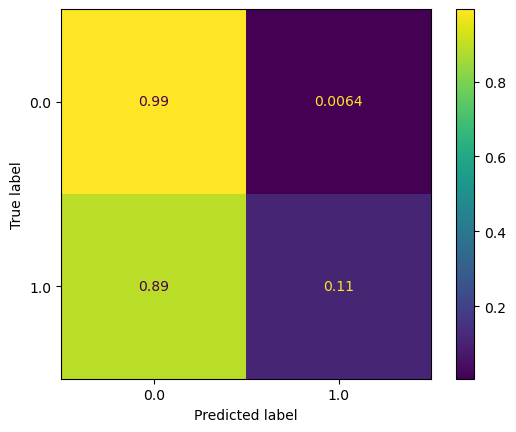


Classification Report
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97 186707050.24709746
         1.0       0.53      0.11      0.18 12819954.791062167

    accuracy                           0.94 199527005.03815964
   macro avg       0.74      0.55      0.57 199527005.03815964
weighted avg       0.92      0.94      0.92 199527005.03815964


Roc Curve


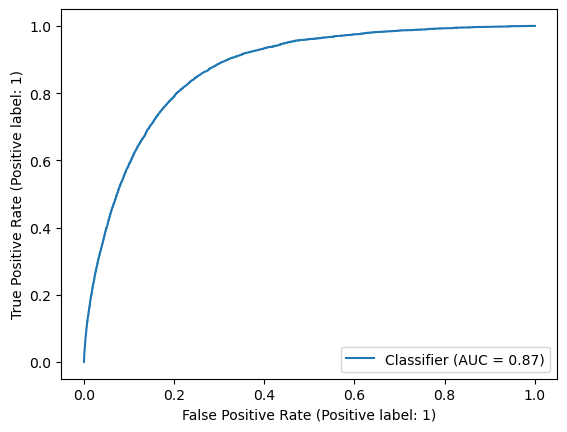

In [14]:
log_regressor_scorer(y_train, y_train_pred, y_train_pred_proba, w_train)

Confusion Matrix


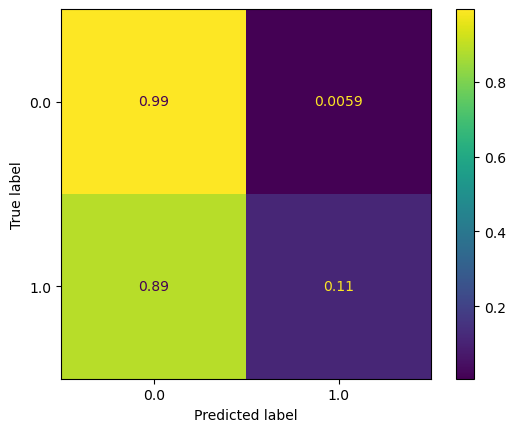


Classification Report
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97 46672849.23711728
         1.0       0.57      0.11      0.19 3188946.5952079524

    accuracy                           0.94 49861795.832325235
   macro avg       0.75      0.55      0.58 49861795.832325235
weighted avg       0.92      0.94      0.92 49861795.832325235


Roc Curve


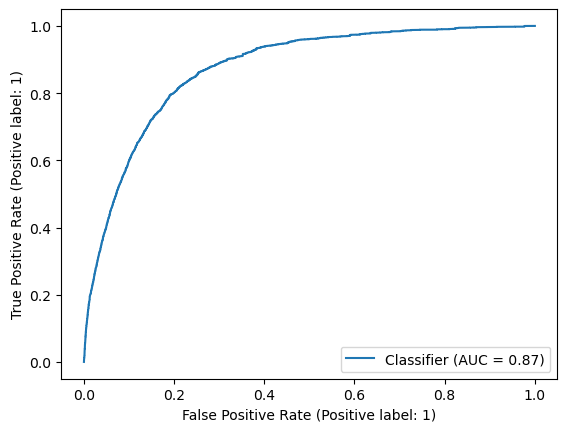

In [15]:
log_regressor_scorer(y_test, y_pred, y_pred_proba, w_test)

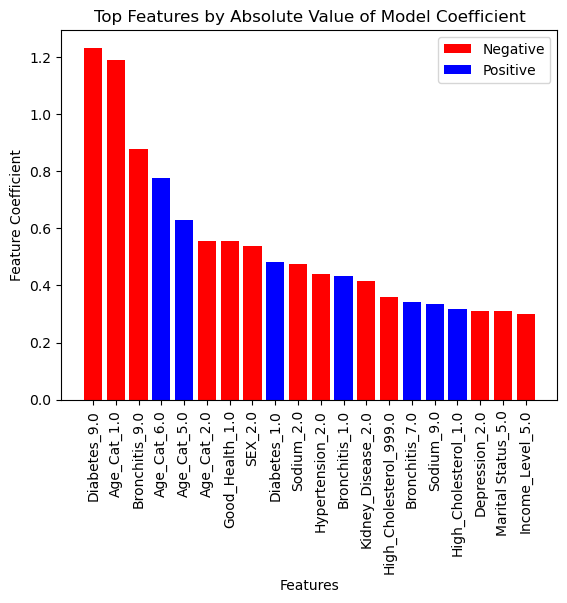

In [16]:
plot_logistic_feature_importance(log_regressor.coef_[0], log_regressor.feature_names_in_, 20)

In [18]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba, sample_weight=w_test)

for tpr_, threshold_ in zip(tpr, threshold):
    if (tpr_ >= 0.80):
        new_threshold = threshold_
        print(tpr_, threshold_)
        break

0.8000068452972127 0.0759783727082677


In [19]:
log_regressor.set_params(threshold=new_threshold)

LogisticRegressionCustom(max_iter=500, threshold=0.0759783727082677)

In [20]:
y_pred_thresh = log_regressor.predict(X_test)
y_pred_thresh_proba = log_regressor.predict_proba(X_test)[:, 1]

In [21]:
any([x[0] != x[1] for x in list(zip(y_pred, y_pred_thresh))]), \
any([x[0] != x[1] for x in list(zip(y_pred_proba, y_pred_thresh_proba))])

(True, False)

Confusion Matrix


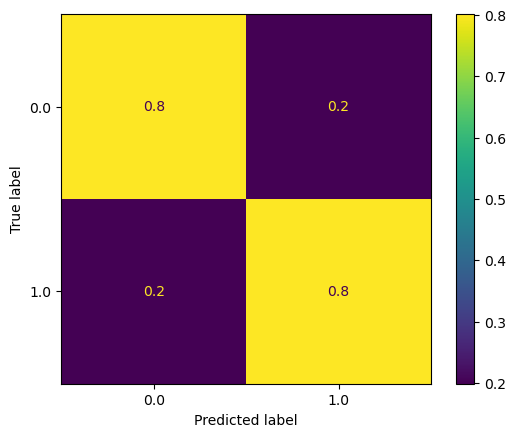


Classification Report
              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88 46672849.23711728
         1.0       0.22      0.80      0.34 3188946.5952079524

    accuracy                           0.80 49861795.832325235
   macro avg       0.60      0.80      0.61 49861795.832325235
weighted avg       0.93      0.80      0.85 49861795.832325235


Roc Curve


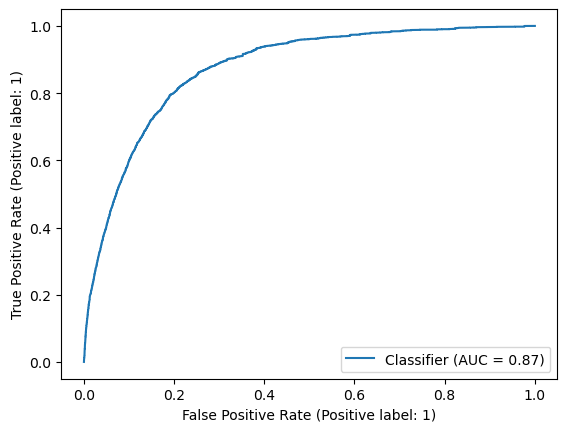

In [22]:
log_regressor_scorer(y_test, y_pred_thresh, y_pred_thresh_proba, w_test)

In [73]:
regressor_test = LogisticRegressionCustom(max_iter=500).fit(X_train, y_train, sample_weight=None)

In [74]:
regressor_test.

{'class_weight': None, 'max_iter': 500, 'threshold': None}

In [76]:
def cv_scorer(name, model, fit_params=None, print_output=True):
    scoring_list = ['roc_auc', 'precision', 'recall', 'f1']
    cv_scores = cross_validate(model, X, y, scoring=scoring_list, fit_params=fit_params)
    if print_output == True:
        print(name + ' cv_scores:')
        print(cv_scores)
        print()
    
    dict_scores = {}
    for score in scoring_list:
        scores_ = cv_scores['test_' + score]
        mean_ = cv_scores['test_' + score].mean()
        std_ = cv_scores['test_' + score].std()
        
        dict_scores[score]= dict(zip(['scores', 'mean', 'std'], [scores_, mean_, std_]))
        
        if print_output == True:
            print(score + ' mean: ' + f'{cv_scores["test_" + score].mean():0.2f}')
            print(score + ' std: ' + f'{cv_scores["test_" + score].std():0.4f}')
            print()
    if print_output == True:
        print()
    
    return {name:dict_scores}

In [79]:
cv_model_results = {}

In [82]:
model_names = ['Logistic Regression, no Threshold', 'Logistic Regression with Threshold']
models = [LogisticRegressionCustom(max_iter=500), LogisticRegressionCustom(max_iter=500, threshold=new_threshold)]
for name, model in zip(model_names, models):
    cv_model_results[name] = cv_scorer(name, model, fit_params=dict(sample_weight=w))

Logistic Regression, no Threshold cv_scores:
{'fit_time': array([27.83104014, 28.97259283, 30.32736945, 30.16947794, 33.16272902]), 'score_time': array([0.16637325, 0.15888143, 0.1598258 , 0.16155148, 0.16846061]), 'test_roc_auc': array([0.83903345, 0.84718019, 0.84505138, 0.8455445 , 0.84173371]), 'test_precision': array([0.51930502, 0.53601815, 0.53558844, 0.51607445, 0.53413655]), 'test_recall': array([0.1044525 , 0.12229843, 0.09835641, 0.11841594, 0.1205022 ]), 'test_f1': array([0.17392241, 0.19915701, 0.16619287, 0.19263158, 0.19664167])}

roc_auc mean: 0.84
roc_auc std: 0.0029

precision mean: 0.53
precision std: 0.0087

recall mean: 0.11
recall std: 0.0096

f1 mean: 0.19
f1 std: 0.0132


Logistic Regression with Threshold cv_scores:
{'fit_time': array([27.42392159, 28.56874132, 30.6786418 , 30.07017875, 33.79496598]), 'score_time': array([0.1636312 , 0.15390182, 0.14914131, 0.15799046, 0.1748836 ]), 'test_roc_auc': array([0.83903345, 0.84718019, 0.84505138, 0.8455445 , 0.841733

In [83]:
cv_model_results

{'Logistic Regression, no Threshold': {'Logistic Regression, no Threshold': {'roc_auc': {'scores': array([0.83903345, 0.84718019, 0.84505138, 0.8455445 , 0.84173371]),
    'mean': 0.8437086455341619,
    'std': 0.0029319869983208415},
   'precision': {'scores': array([0.51930502, 0.53601815, 0.53558844, 0.51607445, 0.53413655]),
    'mean': 0.528224521803746,
    'std': 0.008684489426936509},
   'recall': {'scores': array([0.1044525 , 0.12229843, 0.09835641, 0.11841594, 0.1205022 ]),
    'mean': 0.11280509783094139,
    'std': 0.009585205729773574},
   'f1': {'scores': array([0.17392241, 0.19915701, 0.16619287, 0.19263158, 0.19664167]),
    'mean': 0.18570910882886044,
    'std': 0.013176473234431347}}},
 'Logistic Regression with Threshold': {'Logistic Regression with Threshold': {'roc_auc': {'scores': array([0.83903345, 0.84718019, 0.84505138, 0.8455445 , 0.84173371]),
    'mean': 0.8437086455341619,
    'std': 0.0029319869983208415},
   'precision': {'scores': array([0.21408886, 0.2

# Imbalance

In [50]:
log_regressor.set_params(class_weight='balanced')
log_regressor.fit(X_train, y_train, w_train)

LogisticRegressionCustom(class_weight='balanced', max_iter=500,
                         threshold=0.0759783727082677)

In [54]:
any([x[0] != x[1] for x in list(zip(y_pred, y_pred_bal))])

True

Confusion Matrix


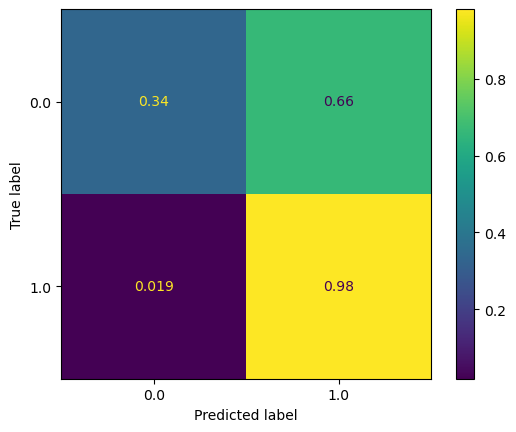


Classification Report
              precision    recall  f1-score   support

         0.0       1.00      0.34      0.50 46672849.23711728
         1.0       0.09      0.98      0.17 3188946.5952079524

    accuracy                           0.38 49861795.832325235
   macro avg       0.54      0.66      0.34 49861795.832325235
weighted avg       0.94      0.38      0.48 49861795.832325235


Roc Curve


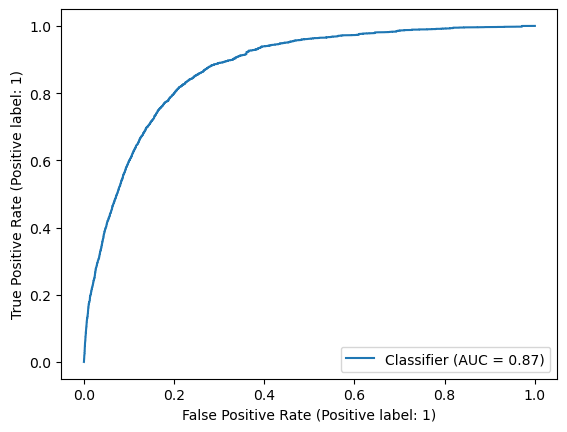

In [51]:
y_pred_bal = log_regressor.predict(X_test)
y_pred_proba_bal = log_regressor.predict_proba(X_test)[:, 1]

log_regressor_scorer(y_test, y_pred_bal, y_pred_proba_bal, sample_weight=w_test)

In [84]:
log_regressor

LogisticRegressionCustom(class_weight='balanced', max_iter=500,
                         threshold=0.0759783727082677)

In [85]:
cv_model_results['LogisticRegression with Class Weights'] = cv_scorer('LogisticRegression with Class Weights', log_regressor, fit_params=dict(sample_weight=w))

LogisticRegression with Class Weights cv_scores:
{'fit_time': array([32.40253949, 29.60738301, 32.24826455, 32.71943116, 46.67478061]), 'score_time': array([0.17428923, 0.18437123, 0.1617496 , 0.16544533, 0.15401101]), 'test_roc_auc': array([0.83875716, 0.84710798, 0.84497008, 0.84512636, 0.84180897]), 'test_precision': array([0.10894054, 0.10747781, 0.10873759, 0.10695611, 0.11114025]), 'test_recall': array([0.98886875, 0.9936586 , 0.9921056 , 0.99534101, 0.98744499]), 'test_f1': array([0.19625976, 0.19397461, 0.19599371, 0.19315628, 0.19979311])}

roc_auc mean: 0.84
roc_auc std: 0.0029

precision mean: 0.11
precision std: 0.0015

recall mean: 0.99
recall std: 0.0029

f1 mean: 0.20
f1 std: 0.0023




In [86]:
cv_model_results

{'Logistic Regression, no Threshold': {'Logistic Regression, no Threshold': {'roc_auc': {'scores': array([0.83903345, 0.84718019, 0.84505138, 0.8455445 , 0.84173371]),
    'mean': 0.8437086455341619,
    'std': 0.0029319869983208415},
   'precision': {'scores': array([0.51930502, 0.53601815, 0.53558844, 0.51607445, 0.53413655]),
    'mean': 0.528224521803746,
    'std': 0.008684489426936509},
   'recall': {'scores': array([0.1044525 , 0.12229843, 0.09835641, 0.11841594, 0.1205022 ]),
    'mean': 0.11280509783094139,
    'std': 0.009585205729773574},
   'f1': {'scores': array([0.17392241, 0.19915701, 0.16619287, 0.19263158, 0.19664167]),
    'mean': 0.18570910882886044,
    'std': 0.013176473234431347}}},
 'Logistic Regression with Threshold': {'Logistic Regression with Threshold': {'roc_auc': {'scores': array([0.83903345, 0.84718019, 0.84505138, 0.8455445 , 0.84173371]),
    'mean': 0.8437086455341619,
    'std': 0.0029319869983208415},
   'precision': {'scores': array([0.21408886, 0.2

# Random Over Sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
help(RandomOverSampler)

In [ ]:
over_sampler = RandomOverSampler()

In [ ]:
X_res, y_res = over_sampler.fit_resample(X, y)

In [ ]:
w_res = w[over_sampler.sample_indices_]
w_res

In [ ]:
X_res_train, X_res_test, y_res_train, y_res_test, w_res_train, w_res_test = train_test_split(X_res, y_res, w_res)

In [ ]:
y_res_train[y_res_train == 1.0].shape[0] / y_res_train.shape[0]

In [ ]:
y_res_test[y_res_test == 1.0].shape[0] / y_res_test.shape[0]

In [ ]:
log_regressor.fit(X_res_train, y_res_train)

In [ ]:
plot_roc_curve(log_regressor, X_res_test, y_res_test)

In [ ]:
y_res_train_pred = log_regressor.predict(X_train)

In [ ]:
print(classification_report(y_train, y_res_train_pred))